In [95]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
from scipy import stats

In [96]:
import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)

In [97]:
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_select, pad_seqs

In [98]:
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# RNN

In [99]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):

    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    for i in range(len(sequence[0])):
        output, hidden = model.forward(sequence[0][i], hidden)
    #Compare final output to target
    loss = criterion(output,label)#.long())
    #Back-propagate
    loss.backward()
    optimizer.step()

    return output, loss.item()

def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model, train_data, test_data, epochs, verbose = False):

    model.train()
    loss_history = []
    acc_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history.append(lossTotal)
        acc = test_acc(model, test_data, hidden_size)
        acc_history.append(acc)

    print(f'loss: {round(lossTotal,1)} ')
    print(f'accuracy: {round(acc,2)} ')
    return loss_history, acc_history

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    correct = 0
    for x,y in testdata:
        hidden = torch.zeros(1, hidden_size)[0]
        for step in x[0]:
            hidden, y_hat = model.get_activations(step,hidden)
        correct += sum(torch.round(y) == torch.round(y_hat)).item()/len(y)
    acc = correct/len(testdata)
    
    if verbose:
        print('test accuracy: %f ' % (acc))

    return acc

def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t
    

# 1 step pretraining

In [100]:
# Generate data
init_values = [1,5,7]

batchsize = 1
scale = 2
hscale = int(scale/2)
len_seq = 1

# + A
operators = ['+']
input_ids = ['A']
seqs_add_a = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
padseqs = pad_seqs(seqs_add_a)
train_inputs = convert_seq2inputs(padseqs*scale, num_classes=13, seq_len=8)
train_add_a = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# + B
operators = ['+']
input_ids = ['B']
seqs_add_b = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
padseqs = pad_seqs(seqs_add_b)
train_inputs = convert_seq2inputs(padseqs*scale, num_classes=13, seq_len=8)
train_add_b = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# + A
operators = ['*']
input_ids = ['A']
seqs_mult_a = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
padseqs = pad_seqs(seqs_mult_a)
train_inputs = convert_seq2inputs(padseqs*scale, num_classes=13, seq_len=8)
train_mult_a = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# + B
operators = ['*']
input_ids = ['B']
seqs_mult_b = generate_sequences(operators, input_ids, len_seq, init_values = init_values, rand = False)
padseqs = pad_seqs(seqs_mult_b)
train_inputs = convert_seq2inputs(padseqs*scale, num_classes=13, seq_len=8)
train_mult_b = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


### combos

# + A and * B

seqs_aAmB = seqs_add_a + seqs_mult_b
padseqs = pad_seqs(seqs_aAmB)
train_inputs = convert_seq2inputs(padseqs*hscale, num_classes=13, seq_len=8)
train_aAmB = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# * A and + B

seqs_mAaB = seqs_mult_a + seqs_add_b 
padseqs = pad_seqs(seqs_mAaB)
train_inputs = convert_seq2inputs(padseqs*hscale, num_classes=13, seq_len=8)
train_mAaB = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)



print('train +a: ', len(train_add_a))
print('train +b: ', len(train_add_b))
print('train *a: ', len(train_mult_a))
print('train *b: ', len(train_mult_b))
print('train +a*b: ', len(train_aAmB))
print('train *a+b: ', len(train_mAaB))

save_dir = 'results/cue_op_combo_090123/'
print(save_dir)

train +a:  18
train +b:  18
train *a:  18
train *b:  18
train +a*b:  18
train *a+b:  18
results/cue_op_combo_090123/


In [136]:
pad_seqs(seqs_mAaB)

[[1, ('*', 'A'), ('X', 'X'), ('X', 'X'), 2],
 [1, ('X', 'X'), ('*', 'A'), ('X', 'X'), 2],
 [1, ('X', 'X'), ('X', 'X'), ('*', 'A'), 2],
 [5, ('*', 'A'), ('X', 'X'), ('X', 'X'), 10],
 [5, ('X', 'X'), ('*', 'A'), ('X', 'X'), 10],
 [5, ('X', 'X'), ('X', 'X'), ('*', 'A'), 10],
 [7, ('*', 'A'), ('X', 'X'), ('X', 'X'), 14],
 [7, ('X', 'X'), ('*', 'A'), ('X', 'X'), 14],
 [7, ('X', 'X'), ('X', 'X'), ('*', 'A'), 14],
 [1, ('+', 'B'), ('X', 'X'), ('X', 'X'), 4],
 [1, ('X', 'X'), ('+', 'B'), ('X', 'X'), 4],
 [1, ('X', 'X'), ('X', 'X'), ('+', 'B'), 4],
 [5, ('+', 'B'), ('X', 'X'), ('X', 'X'), 8],
 [5, ('X', 'X'), ('+', 'B'), ('X', 'X'), 8],
 [5, ('X', 'X'), ('X', 'X'), ('+', 'B'), 8],
 [7, ('+', 'B'), ('X', 'X'), ('X', 'X'), 10],
 [7, ('X', 'X'), ('+', 'B'), ('X', 'X'), 10],
 [7, ('X', 'X'), ('X', 'X'), ('+', 'B'), 10]]

In [117]:
figpath = '../figures/cue_op_combo_110123/'

In [101]:
num_classes = 14
input_size = num_classes
output_size = batchsize
hidden_size = 20
num_layers = 1
learningRate = 0.005

In [102]:
# train on + A * B and then switch operation pair

epochs = 1400
num_sims = 100

one_shot_acc = []
losses=[]
accs = []
losses_rand = []
accs_rand = []

for j in range(num_sims):
    print('### rep', j, ' ###')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model, train_aAmB, train_aAmB, epochs)
    
    acc_1shot = test_acc(model, train_mAaB, hidden_size, verbose = True)
    one_shot_acc.append(acc_1shot)
    print('----- 1 shot accuracy ------')
    
    model2 = shuffle_weights(model)
    
    loss2, acc2 = run_acc(model, train_mAaB, train_mAaB, epochs)
    losses.append(loss1+loss2)
    accs.append(acc1+acc2)
    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model2, train_mAaB, train_mAaB, epochs)
    losses_rand.append(loss3)
    accs_rand.append(acc3)


### rep 0  ###
loss: 1.0 
accuracy: 0.94 
test accuracy: 0.055556 
----- 1 shot accuracy ------
loss: 0.9 
accuracy: 1.0 
loss: 0.0 
accuracy: 1.0 
### rep 1  ###
loss: 0.8 
accuracy: 1.0 
test accuracy: 0.222222 
----- 1 shot accuracy ------
loss: 1.3 
accuracy: 1.0 
loss: 0.1 
accuracy: 1.0 
### rep 2  ###
loss: 45.6 
accuracy: 0.83 
test accuracy: 0.333333 
----- 1 shot accuracy ------
loss: 0.6 
accuracy: 0.94 
loss: 0.0 
accuracy: 1.0 
### rep 3  ###
loss: 0.2 
accuracy: 1.0 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 0.3 
accuracy: 1.0 
loss: 0.9 
accuracy: 1.0 
### rep 4  ###
loss: 16.6 
accuracy: 0.94 
test accuracy: 0.055556 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 0.1 
accuracy: 1.0 
### rep 5  ###
loss: 0.4 
accuracy: 1.0 
test accuracy: 0.111111 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 0.4 
accuracy: 1.0 
### rep 6  ###
loss: 1.2 
accuracy: 0.78 
test accuracy: 0.111111 
----- 1 shot accuracy ------
loss: 0.0 
accur

loss: 2.1 
accuracy: 1.0 
test accuracy: 0.166667 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 0.2 
accuracy: 1.0 
### rep 56  ###
loss: 8.4 
accuracy: 0.44 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 0.3 
accuracy: 1.0 
### rep 57  ###
loss: 3.7 
accuracy: 0.83 
test accuracy: 0.111111 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0 
loss: 0.0 
accuracy: 1.0 
### rep 58  ###
loss: 14.7 
accuracy: 0.61 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 0.3 
accuracy: 1.0 
loss: 0.0 
accuracy: 1.0 
### rep 59  ###
loss: 15.7 
accuracy: 0.89 
test accuracy: 0.222222 
----- 1 shot accuracy ------
loss: 0.9 
accuracy: 0.72 
loss: 0.2 
accuracy: 1.0 
### rep 60  ###
loss: 0.4 
accuracy: 1.0 
test accuracy: 0.277778 
----- 1 shot accuracy ------
loss: 0.0 
accuracy: 1.0 
loss: 0.0 
accuracy: 1.0 
### rep 61  ###
loss: 8.6 
accuracy: 0.78 
test accuracy: 0.000000 
----- 1 shot accuracy ------
loss: 0.1 
accuracy: 1.0

In [121]:
len(one_shot_acc)

100

In [123]:
# save
savepath = '../results/cue_op_combo_090123/'

fileObject = open(savepath + 'loss_aAmB_mAaB', 'wb')
pickle.dump(losses , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_aAmB_mAaB', 'wb')
pickle.dump(accs , fileObject)
fileObject.close()

fileObject = open(savepath + 'loss_mAaB_rand', 'wb')
pickle.dump(losses_rand , fileObject)
fileObject.close()
fileObject = open(savepath + 'acc_mAaB_rand', 'wb')
pickle.dump(accs_rand , fileObject)
fileObject.close()

fileObject = open(savepath + 'acc_mAaB_1shot', 'wb')
pickle.dump(one_shot_acc, fileObject)
fileObject.close()

In [115]:
with open(savepath + 'loss_aAmB_mAaB', 'rb') as file:
    losses = pickle.load(file)
with open(savepath + 'acc_aAmB_mAaB', 'rb') as file:
    accs = pickle.load(file)
with open(savepath + 'loss_mAaB_rand', 'rb') as file:
    losses_rand = pickle.load(file)
with open(savepath + 'acc_mAaB_rand', 'rb') as file:
    accs_rand = pickle.load(file)


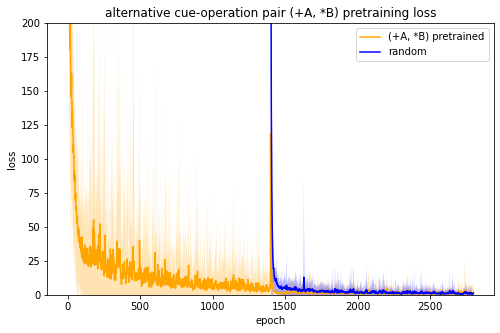

In [125]:
lr = np.array(losses).T
r = np.array(losses_rand).T
plt.figure(figsize=(8,5))
NNplt.plotNN_shifted([lr],\
                    labels = ['(+A, *B) pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = epochs)
plt.title('alternative cue-operation pair (+A, *B) pretraining loss')
plt.ylim(0,200)
plt.savefig(figpath+'loss_curve.png')

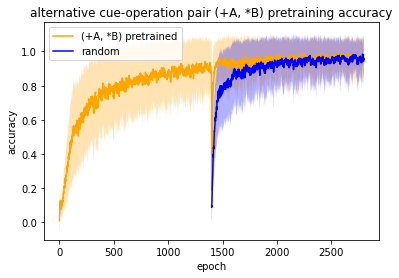

In [126]:
lr = np.array(accs).T
r = np.array(accs_rand).T

NNplt.plotNN_shifted([lr],\
                    labels = ['(+A, *B) pretrained'],\
                    colors = ['orange'],\
                    shift = 0)
NNplt.plotNN_shifted([r],\
                    labels = ['random'],\
                    colors = ['blue'],\
                    shift = epochs)
plt.ylabel('accuracy')
plt.title('alternative cue-operation pair (+A, *B) pretraining accuracy')
plt.savefig(figpath+'acc_plot.png')

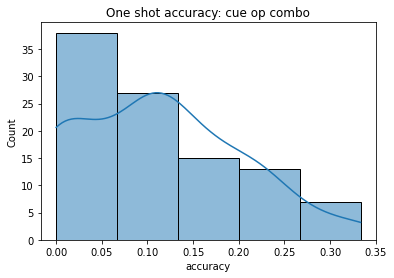

In [134]:
import seaborn as sns

sns.histplot(one_shot_acc, kde=True, bins=5)
plt.xlabel('accuracy')
plt.title('One shot accuracy: cue op combo')
plt.savefig(figpath+'cue_op_1shotacc.png')


In [129]:
np.mean(one_shot_acc)

0.11333333333333333

In [130]:
np.std(one_shot_acc)

0.08920776138519575

In [133]:
print(stats.ttest_1samp(one_shot_acc, 0, alternative = 'greater'))


Ttest_1sampResult(statistic=12.640743487012022, pvalue=1.1149229204954397e-22)


In [1]:
4*2*4*2*4

256

In [2]:
12*4

48

In [3]:
16*4

64

In [7]:
576/4*3

432.0